# Two Sample Tutorial - PC9 cancer cell line

Here is a second walkthrough for using VeloCycle for manfiold-constrained RNA velocity estimation of the cell cycle.

This more advanced tutorial estimates the cell cycle speed for a paired dataset of two PC9 lung adenocarcinoma cell line samples from Aissa et al. 2021, before and after treatment with the drug erlotinib.

We suggest starting with the first tutorial and then proceeding to this one.

For a more detailed overview of the analyses performed with this dataset in our original study, please see the more extensive Jupyter notebook offered on the corresponding Google Drive page:

https://drive.google.com/drive/folders/1G_VPLpD8trPBZ8F8h7cBzcPPkKPn2Fik?usp=drive_link

For a simple tutorial on a single dataset of human fibroblasts, please see our Github page for the following notebook:

Tutorial_Capolupo_HumanFibroblasts_OneSample.ipynb

## Load VeloCycle as well as related single cell and machine learning packages

In [1]:
import velocycle as vc
from velocycle import *

In [2]:
# generic & ml
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import pyro
import copy
import scipy
import pycircstat
import pickle
from scipy.stats import pearsonr
from scipy.linalg import lstsq
import statsmodels.api as sm

# scRNA-seq
import scanpy as sc
import anndata

## Optional: set the default device to the GPU

If you do not have a GPU on your device, please set USE_GPU = False to run the rest of this notebook. For large datasets, runtimes will be slower.

In [3]:
USE_GPU = False
if USE_GPU and torch.cuda.is_available():
    print("Will use GPU")
    device = torch.device("cuda:0")
else:
    print("Will use CPU")
    device = torch.device("cpu")

Will use CPU


## Download dataset and perform some gene filtering based on low spliced/unspliced detection

In [4]:
import anndata

full_adatas = {   
    "PC9D0": sc.read_h5ad("aissa_pc9_d0.h5ad"),
    "PC9D3": sc.read_h5ad("aissa_pc9_d3.h5ad"),
}

for a in full_adatas.keys():
    sc.pp.filter_genes(full_adatas[a], min_cells=int((full_adatas[a].n_obs)*0.05))
    
data = anndata.concat(full_adatas, label="batch", join ="outer")

In [5]:
data = data[:, data.layers["unspliced"].toarray().mean(0) > 0.1].copy()
data = data[:, data.layers["spliced"].toarray().mean(0) > 0.1].copy()

In [6]:
# Create design matrix for dataset with a single sample/batch
batch_design_matrix = preprocessing.make_design_matrix(data, ids="batch")

In [7]:
# Rough approximation of the cell cycle phase using categorical approaches 
sc.tl.score_genes_cell_cycle(data, s_genes=utils.S_genes_human, g2m_genes=utils.G2M_genes_human)

In [8]:
# Create size-normalized data layers, which are only used to obtain a PCA phase prior
# VeloCycle operates on the raw counts and has a built-in count factor term
preprocessing.normalize_total(data)

In [9]:
# Get biologically-relevant gene set to use for velocity estimation
# Three sizes are offered in VeloCycle, taken from the literature: 
# Large (Gene Ontology), Medium (DeepCycle), and Small (Seurat)

# Here, we use the medium gene set for the tutorial 
# because manifold and velocity estimation has a faster runtime with fewer genes
full_keep_genes = utils.get_cycling_gene_set(size="Medium", species="Human")

## Initialize a "cycle" and "phase" object, which will store the manifold geometry and coordinates

Geometry: fourier series coefficients describing each gene

Coordinates: phase position for each cell on the cell cycle circle

In [10]:
cycle_prior = cycle.Cycle.trivial_prior(gene_names=full_keep_genes, harmonics=1)

In [11]:
# Keep only genes from biologically-relevant gene set that are present in the current dataset
cycle_prior, data_to_fit = preprocessing.filter_shared_genes(cycle_prior, data, filter_type="intersection")

In [12]:
# Update the priors for gene harmonics
# to gene-specific means and stds
S = data_to_fit.layers['spliced'].toarray()
S_means = S.mean(axis=0) #sum over cells
nu0 = np.log(S_means)

# Mean prior
S_frac_means=np.vstack((nu0, 0*nu0, 0*nu0))
cycle_prior.set_means(S_frac_means)

# Standard deviation prior
nu0std = np.std(np.log(S+1), axis=0)/2
S_frac_stds=np.vstack((nu0std, 0.5*nu0std, 0.5*nu0std))
cycle_prior.set_stds(S_frac_stds)

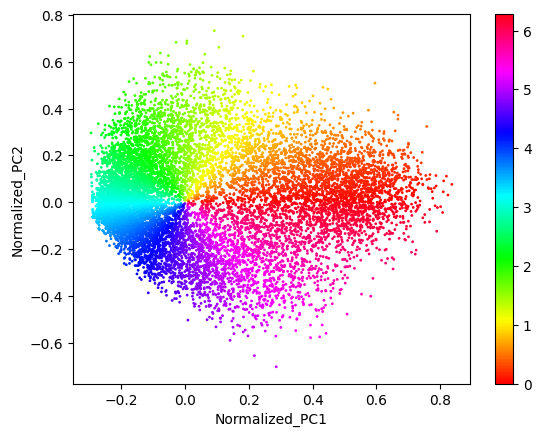

In [13]:
# Obtain a PCA prior for individual cell phases
# The prior for cell cycle coordinates are taken from the first two components of the PCA
phase_prior = phases.Phases.from_pca_heuristic(data_to_fit, 
                                               genes_to_use=utils.get_cycling_gene_set(size="Small", species="Human"), 
                                               layer='S_sz',
                                               concentration=10.0, plot=True, small_count=1)

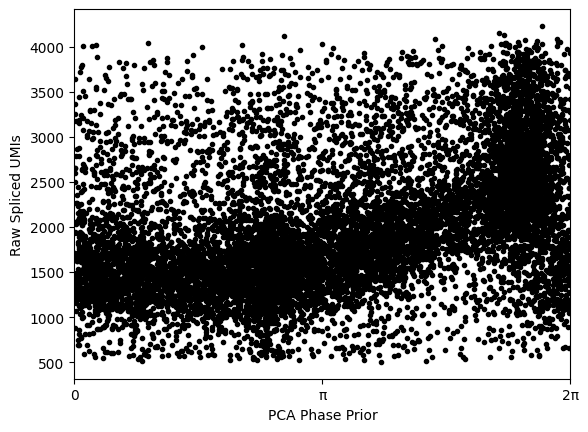

In [14]:
# Shift the phase prior to have maximum correlation with the total raw UMI counts
preprocessing.invert_direction(cycle_prior, phase_prior) # Invert cell cycle prior orientation
(shift, maxcor, allcor) = phase_prior.max_corr(data_to_fit.obs.n_scounts)
phase_prior.rotate(angle=-shift)
plt.plot(phase_prior.phis, data_to_fit.obs.n_scounts, '.', c='black')
plt.xlim(0, np.pi*2)
plt.xticks([0, np.pi, 2*np.pi],["0", "π", "2π"])
plt.xlabel("PCA Phase Prior")
plt.ylabel("Raw Spliced UMIs")
plt.show()

## Run the manifold-learning module

In [15]:
pyro.clear_param_store()

In [16]:
import datetime
start_time = datetime.datetime.now()

In [17]:
# Set batch effect std prior to close to zero for first dataset and non-zero to the second dataset
σΔν = torch.ones((batch_design_matrix.shape[1], S.shape[1], 1))
σΔν[0, :, :] = 0.001
σΔν[1, :, :] = 0.1
condition_on_dict = {}

In [18]:
# Call a preprocessing function to metaparameters to provide to Pyro
metapar = preprocessing.preprocess_for_phase_estimation(anndata=data_to_fit, 
                                          cycle_obj=cycle_prior, 
                                          phase_obj=phase_prior, 
                                          design_mtx=batch_design_matrix,
                                          n_harmonics=1,
                                          σΔν=σΔν.float().to(device),
                                          device = device,
                                          condition_on=condition_on_dict)

In [19]:
# Define a pyro object for phase inference
phase_fit = phase_inference_model.PhaseFitModel(metaparams=metapar, 
                                                condition_on=condition_on_dict)

In [20]:
# Optional commands to check the plate dimensions for the model
#phase_fit.check_model()
#phase_fit.check_guide()

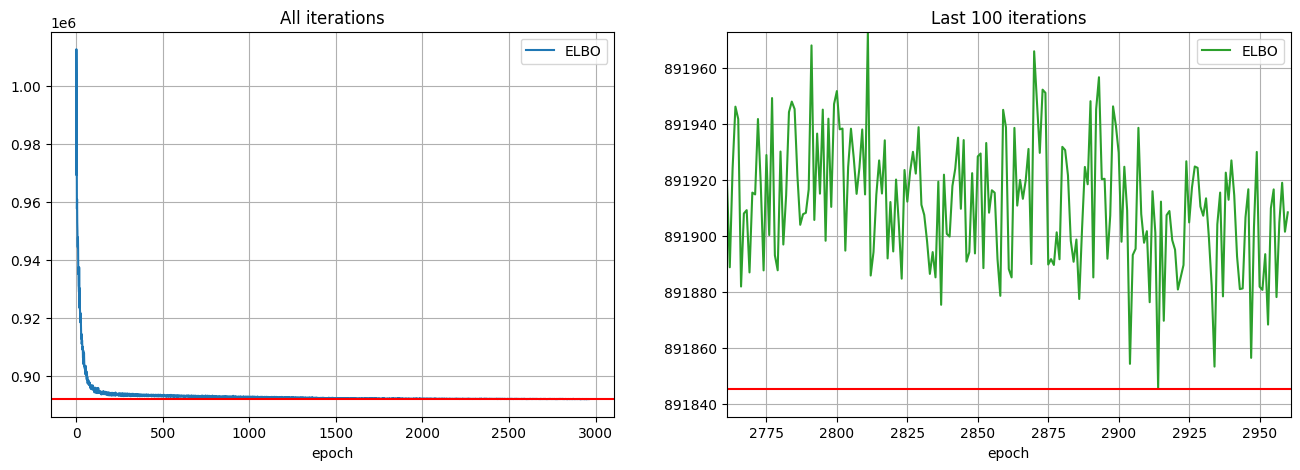

In [21]:
# Perform training using a decaying learning rate
num_steps = 3000
initial_lr = 0.03
final_lr = 0.005
gamma = final_lr / initial_lr
lrd = gamma ** (1 / num_steps)
adam = pyro.optim.ClippedAdam({'lr': initial_lr, 'lrd': lrd, 'betas': (0.80, 0.99)})

phase_fit.fit(optimizer=adam, num_steps=num_steps)

In [22]:
end_time = datetime.datetime.now()
total_runtime = end_time - start_time
print("Total runtime:", total_runtime)

Total runtime: 0:04:07.143599


## Visualize the obtained manifold coordinates (phase) and geometry (gene harmonics) 

In [23]:
# Put estimations in new objects
cycle_pyro = phase_fit.cycle_pyro
phase_pyro = phase_fit.phase_pyro

In [24]:
fit_ElogS = phase_fit.posterior["ElogS"].squeeze().numpy() # raw counts
fit_ElogS2 = phase_fit.posterior["ElogS2"].squeeze().numpy() # size-normalized counts for cleaner visualization

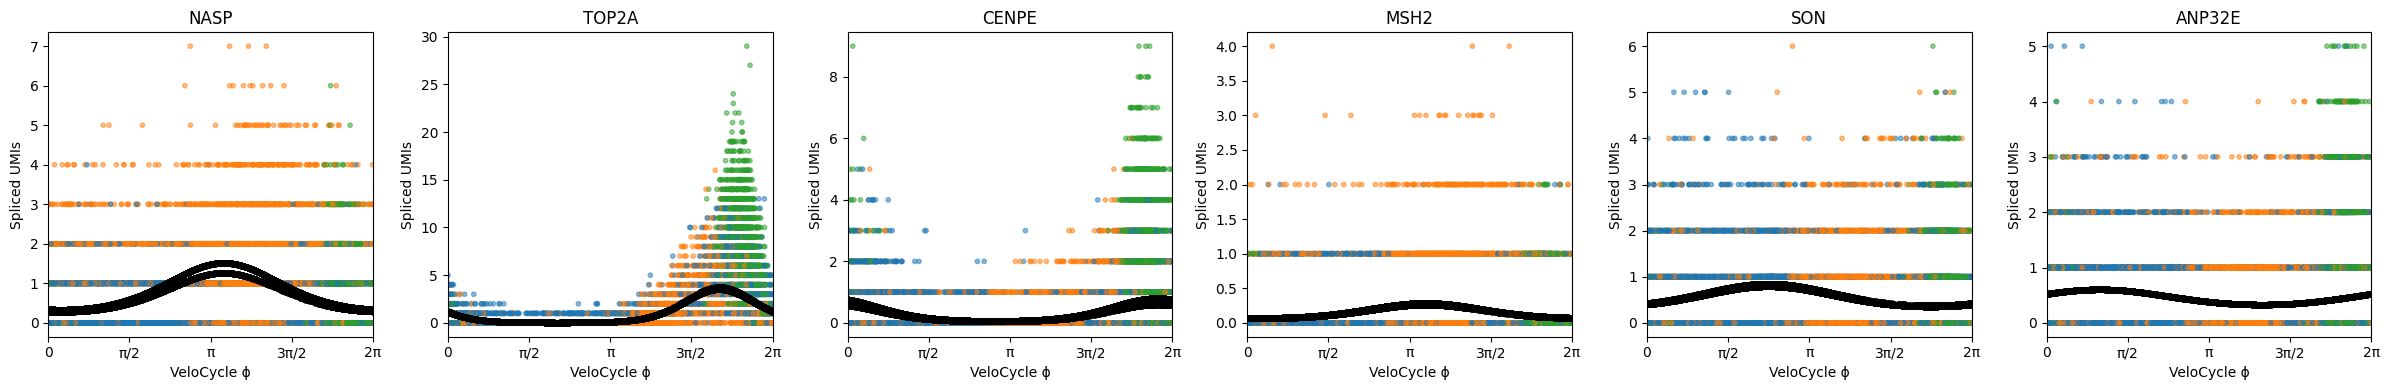

In [25]:
# Visualize the results for a subset of genes, colored by categorical cell cycle phase
name2color = {'G1':"tab:blue", 'S':"tab:orange", 'G2M':"tab:green"}
gene_list = ["NASP", "TOP2A", "CENPE", "MSH2", "SON", "ANP32E"]
gene_names = np.array(data_to_fit.var.index)
plt.figure(None,(24, 4))
ix = 1
for i in range(0, len(gene_list)):
    g = gene_list[i]
    plt.subplot(1, len(gene_list), ix)
    plt.scatter(phase_pyro.phis, 
                metapar.S[np.where(gene_names==g)[0][0], :].squeeze().cpu().numpy(), 
                s=10, alpha=0.5, c=[name2color[x] for x in data_to_fit.obs["phase"]])
    plt.scatter(phase_pyro.phis, 
                np.exp(fit_ElogS2[np.where(gene_names==g)[0][0], :]), 
                s=10, c="black")
    plt.title(g)
    plt.xlabel("VeloCycle ϕ")
    plt.ylabel("Spliced UMIs")
    plt.xlim(0, 2*np.pi)
    plt.xticks([0, np.pi/2, np.pi, 3*np.pi/2, 2*np.pi],["0", "π/2", "π", "3π/2", "2π"])
    ix+=1
plt.tight_layout()
plt.show()

In [26]:
# Examine the periodicity and geometry of fitted genes
xs = phase_fit.fourier_coef[1]
ys = phase_fit.fourier_coef[2]
r = np.log10( np.sqrt(xs**2+ys**2) / phase_fit.fourier_coef_sd[1:, :].sum(0) )
angle = np.arctan2(xs, ys)
angle = (angle)%(2*np.pi)

phis_df = pd.DataFrame([angle, r])
phis_df.columns = data_to_fit.var.index

cycle_data_frame = pd.concat([phase_fit.cycle_pyro.means, phase_fit.cycle_pyro.stds, phis_df]).T
cycle_data_frame.columns = ["nu0 mean", "nu1sin mean", "nu1cos mean", "nu0 std", "nu1sin std", "nu1cos std", "peak_phase", "amplitude"]
cycle_data_frame["is_seurat_marker"] = [True if i in list(utils.S_genes_human)+list(utils.G2M_genes_human) else False for i in cycle_data_frame.index]
cycle_data_frame.head()

,nu0 mean,nu1sin mean,nu1cos mean,nu0 std,nu1sin std,nu1cos std,peak_phase,amplitude,is_seurat_marker
ANKRD17,-1.105276,0.236584,-0.401592,0.016362,0.022945,0.022432,2.609215,1.011643,False
ANLN,-0.313510,-0.553157,0.502838,0.009875,0.014019,0.013290,5.450172,1.437333,True
ANP32B,1.191634,0.206792,-0.277289,0.006409,0.009177,0.009139,2.500809,1.276139,False
ANP32E,-0.609262,0.257553,0.157696,0.012221,0.019120,0.015981,1.021392,0.934692,True
ASPM,-1.105325,-0.421812,1.287085,0.011359,0.019817,0.014755,5.966489,1.593039,False


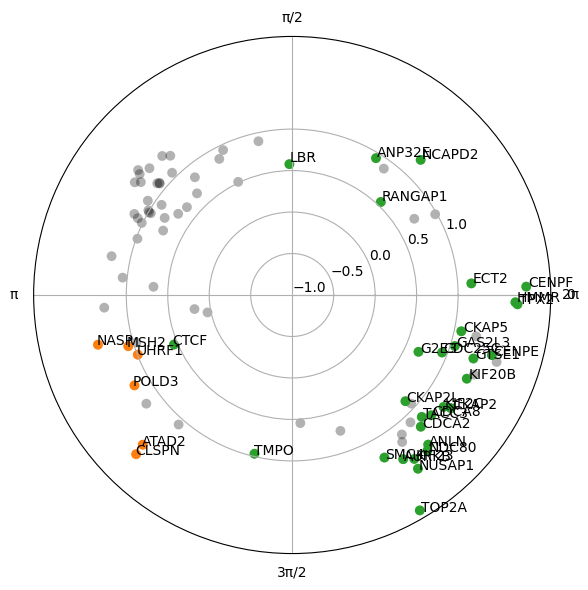

In [27]:
# View gene periodicity estimates with a polar plot
phase_fit.polar_plot()

## Run the velocity-learning module to infer a constant velocity

Later we will re-run this module to infer a non-constant (periodic) velocity

In [28]:
pyro.clear_param_store()

In [29]:
start_time = datetime.datetime.now()

In [30]:
condition_design_matrix = copy.deepcopy(batch_design_matrix) # they are the same since there is only one sample

In [31]:
speed_prior = angularspeed.AngularSpeed.trivial_prior(condition_names=["PC9D0", "PC9D3"], harmonics=0)

In [32]:
# Condition the model on variables learned during manifold-learning
condition_on_dict = {"ϕxy":phase_pyro.phi_xy_tensor.T.to(device),
                     "ν": cycle_pyro.means_tensor.T.unsqueeze(-2).to(device),
                     "Δν": torch.tensor(phase_fit.delta_nus).to(device),
                     "shape_inv": torch.tensor(phase_fit.disp_pyro).unsqueeze(-1).to(device)}

In [33]:
metaparameters_velocity = preprocessing.preprocess_for_velocity_estimation(data_to_fit, 
                                                             cycle_pyro, 
                                                             phase_pyro, 
                                                             speed_prior,
                                                             condition_design_matrix.float(), 
                                                             batch_design_matrix.float(), 
                                                             n_harmonics=1,
                                                             count_factor=metapar.count_factor,
                                                             ω_n_harmonics=0, 
                                                             device=device, 
                                                             condition_on=condition_on_dict)

In [34]:
velocity_fit0 = velocity_inference_model.VelocityFitModel(metaparams=metaparameters_velocity, 
                                                         condition_on=condition_on_dict)

In [35]:
#velocity_fit0.check_model()
#velocity_fit0.check_guide()

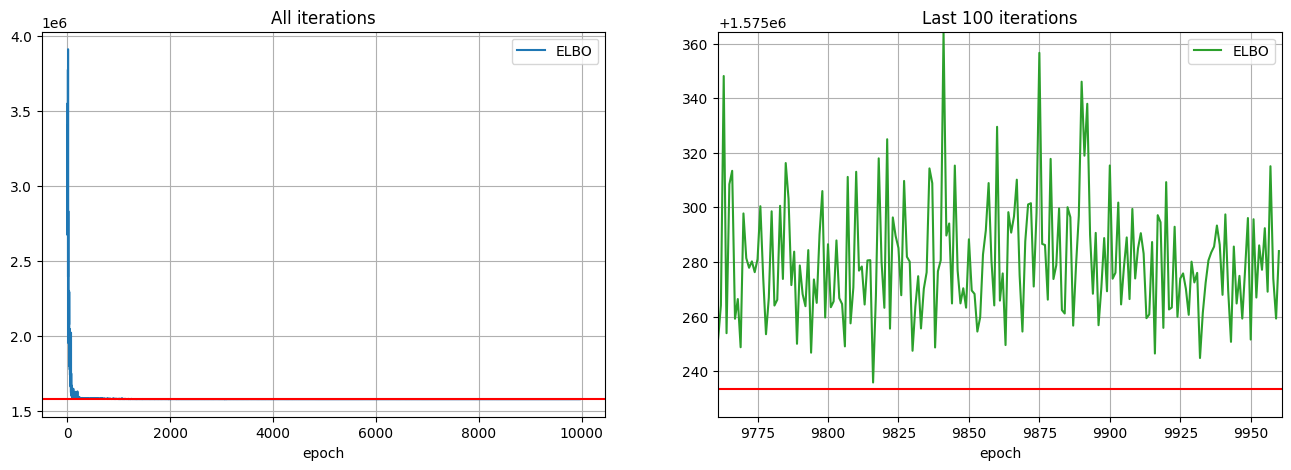

In [36]:
num_steps = 10000
initial_lr = 0.03
final_lr = 0.005
gamma = final_lr / initial_lr
lrd = gamma ** (1 / num_steps)
adam = pyro.optim.ClippedAdam({'lr': initial_lr, 'lrd': lrd, 'betas': (0.80, 0.99)})

velocity_fit0.fit(optimizer=adam, num_steps=num_steps)

In [37]:
end_time = datetime.datetime.now()
total_runtime = end_time - start_time
print("Total runtime:", total_runtime)

Total runtime: 0:18:16.318904


In [38]:
# Put estimations in new objects
cycle_pyro = velocity_fit0.cycle_pyro
phase_pyro = velocity_fit0.phase_pyro
speed_pyro = velocity_fit0.speed_pyro

fit_ElogS = velocity_fit0.posterior["ElogS"].squeeze()
fit_ElogU = velocity_fit0.posterior["ElogU"].squeeze()

fit_ElogS2 = velocity_fit0.posterior["ElogS2"].squeeze()
fit_ElogU2 = velocity_fit0.posterior["ElogU2"].squeeze()

log_gammas = velocity_fit0.log_gammas
log_betas = velocity_fit0.log_betas

In [39]:
speed_pyro.means

,PC9D0,PC9D3
nu0,0.384185,0.325681


In [40]:
# Store entire posterior sampling into an object
full_pps_velo = velocity_fit0.posterior

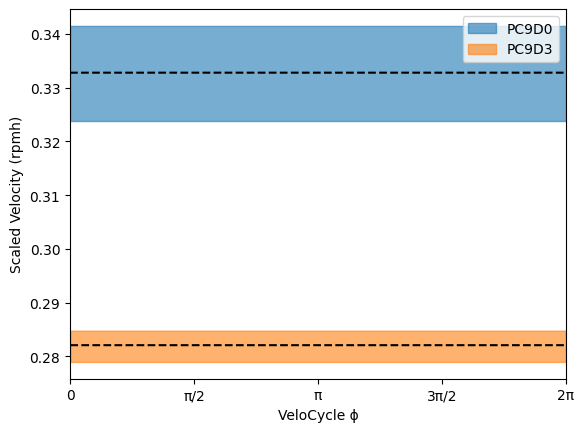

In [41]:
# Visualize the constant velocity estimate
omega = full_pps_velo["ω"].squeeze().numpy() / torch.exp(torch.mean(full_pps_velo["logγg"].squeeze().mean(0).detach())).numpy()
phi = phase_pyro.phis
omegas = []
phis = []
n2n = {"PC9D0":0, "PC9D3":1}
ids = np.array([n2n[i] for i in np.array(data_to_fit.obs["batch"])])
for i in range(len(data_to_fit.obs["batch"].unique())):
    omega1 = omega[:,np.where(ids == i)]
    phi1 = phi[np.where(ids == i)]
    omegas.append(omega1)
    phis.append(phi1)

labels = np.array(data_to_fit.obs["batch"].unique())

colors = ["tab:blue", "tab:orange"]
for i in range(len(omegas)):
    plt.plot(phis[i][np.argsort(phis[i])], omegas[i].mean(0)[0][np.argsort(phis[i])], c="black", linestyle='dashed')
    
    tmp5 = np.percentile(omega[:, ids==i], 5, axis=0)
    tmp95 = np.percentile(omega[:, ids==i], 95, axis=0)
    phi_i = phi[ids==i] 
    plt.fill_between(x=phi_i[np.argsort(phi_i)],
                     y1=tmp5[np.argsort(phi_i)], 
                     y2=tmp95[np.argsort(phi_i)], 
                     alpha=0.6, color=colors[i], label = labels[i])

plt.xlabel("VeloCycle ϕ")
plt.ylabel("Scaled Velocity (rpmh)")
plt.xlim(0, 2*np.pi)
plt.xticks([0, np.pi/2, np.pi, 3*np.pi/2, 2*np.pi],["0", "π/2", "π", "3π/2", "2π"])
plt.legend()
plt.show()

## Run the velocity-learning module to infer a non-constant (periodic) velocity

In [42]:
pyro.clear_param_store()

In [43]:
start_time = datetime.datetime.now()

In [44]:
condition_design_matrix = copy.deepcopy(batch_design_matrix)

In [45]:
speed_prior = angularspeed.AngularSpeed.trivial_prior(condition_names=["PC9D0", "PC9D3"], harmonics=1)
speed_prior.stds.loc["nu1_cos"] = [0.005, 0.005]
speed_prior.stds.loc["nu1_sin"] = [0.005, 0.005]

In [46]:
condition_on_dict = {"ϕxy":phase_pyro.phi_xy_tensor.T.to(device),
                     "ν": cycle_pyro.means_tensor.T.unsqueeze(-2).to(device),
                     "Δν": torch.tensor(phase_fit.delta_nus).to(device),
                     "shape_inv": torch.tensor(phase_fit.disp_pyro).unsqueeze(-1).to(device)}

In [47]:
metaparameters_velocity = preprocessing.preprocess_for_velocity_estimation(data_to_fit, 
                                                             cycle_pyro, 
                                                             phase_pyro, 
                                                             speed_prior,
                                                             condition_design_matrix.float(), 
                                                             batch_design_matrix.float(), 
                                                             n_harmonics=1,
                                                             count_factor=metapar.count_factor,
                                                             ω_n_harmonics=1, 
                                                             device=device, 
                                                             condition_on=condition_on_dict)

In [48]:
velocity_fit1 = velocity_inference_model.VelocityFitModel(metaparams=metaparameters_velocity, condition_on=condition_on_dict)

In [49]:
# velocity_fit1.check_model()
# velocity_fit1.check_guide()

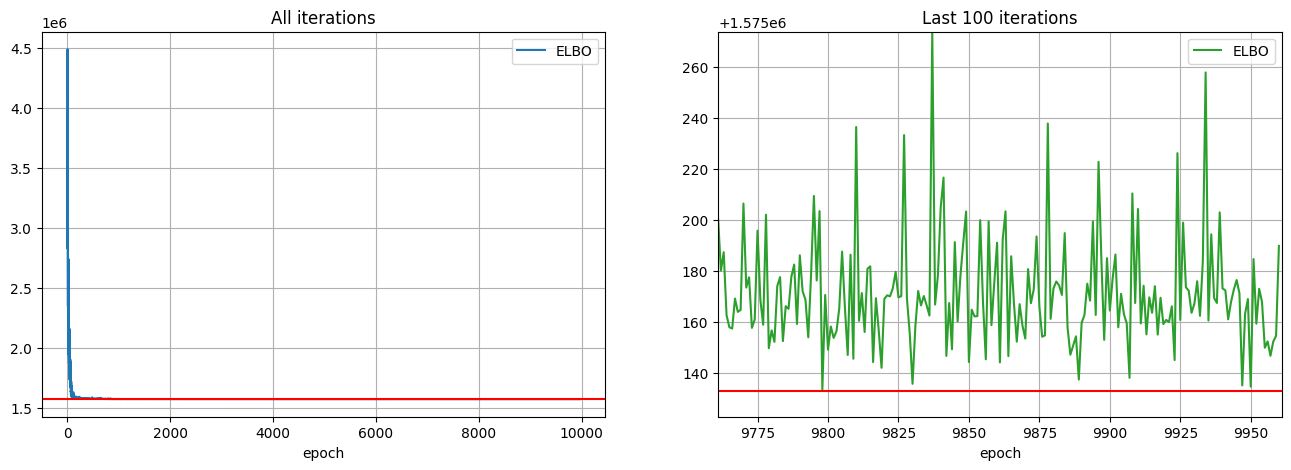

In [50]:
num_steps = 10000
initial_lr = 0.03
final_lr = 0.005
gamma = final_lr / initial_lr
lrd = gamma ** (1 / num_steps)
adam = pyro.optim.ClippedAdam({'lr': initial_lr, 'lrd': lrd, 'betas': (0.80, 0.99)})

velocity_fit1.fit(optimizer=adam, num_steps=num_steps)

In [51]:
end_time = datetime.datetime.now()
total_runtime = end_time - start_time
print("Total runtime:", total_runtime)

Total runtime: 0:18:18.521945


In [52]:
# Put estimations in new objects
cycle_pyro = velocity_fit1.cycle_pyro
phase_pyro = velocity_fit1.phase_pyro
speed_pyro = velocity_fit1.speed_pyro

fit_ElogS = velocity_fit1.posterior["ElogS"].squeeze()
fit_ElogU = velocity_fit1.posterior["ElogU"].squeeze()

fit_ElogS2 = velocity_fit1.posterior["ElogS2"].squeeze()
fit_ElogU2 = velocity_fit1.posterior["ElogU2"].squeeze()

log_gammas = velocity_fit1.log_gammas
log_betas = velocity_fit1.log_betas

In [53]:
speed_pyro.means

,PC9D0,PC9D3
nu0,0.282131,0.239703
nu1_cos,-0.030562,0.002719
nu1_sin,0.041300,0.004563


In [54]:
# Store entire posterior sampling into an object
full_pps_velo = velocity_fit1.posterior

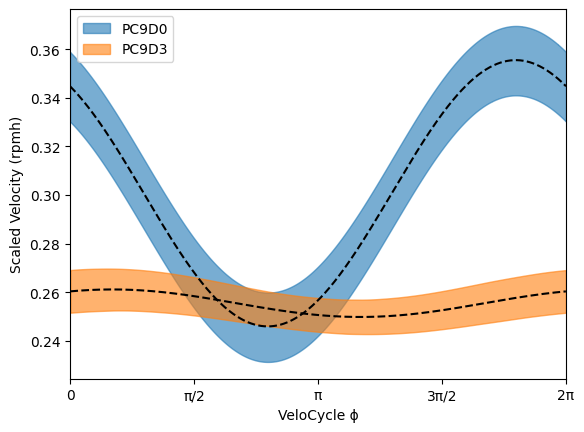

In [55]:
# Visualize the constant velocity estimate
omega = full_pps_velo["ω"].squeeze().numpy() / torch.exp(torch.mean(full_pps_velo["logγg"].squeeze().mean(0).detach())).numpy()
phi = phase_pyro.phis
omegas = []
phis = []
n2n = {"PC9D0":0, "PC9D3":1}
ids = np.array([n2n[i] for i in np.array(data_to_fit.obs["batch"])])
for i in range(len(data_to_fit.obs["batch"].unique())):
    omega1 = omega[:,np.where(ids == i)]
    phi1 = phi[np.where(ids == i)]
    omegas.append(omega1)
    phis.append(phi1)

labels = np.array(data_to_fit.obs["batch"].unique())

colors = ["tab:blue", "tab:orange"]
for i in range(len(omegas)):
    plt.plot(phis[i][np.argsort(phis[i])], omegas[i].mean(0)[0][np.argsort(phis[i])], c="black", linestyle='dashed')
    
    tmp5 = np.percentile(omega[:, ids==i], 5, axis=0)
    tmp95 = np.percentile(omega[:, ids==i], 95, axis=0)
    phi_i = phi[ids==i] 
    plt.fill_between(x=phi_i[np.argsort(phi_i)],
                     y1=tmp5[np.argsort(phi_i)], 
                     y2=tmp95[np.argsort(phi_i)], 
                     alpha=0.6, color=colors[i], label = labels[i])

plt.xlabel("VeloCycle ϕ")
plt.ylabel("Scaled Velocity (rpmh)")
plt.xlim(0, 2*np.pi)
plt.xticks([0, np.pi/2, np.pi, 3*np.pi/2, 2*np.pi],["0", "π/2", "π", "3π/2", "2π"])
plt.legend()
plt.show()

## Perform some downstream analysis and make visualizations

### (1) What is the cell cycle period in a real (hours) time scale?

In [56]:
# PC9 D0
from scipy.integrate import trapz
period = []

mean_gamma  = np.exp(np.mean(velocity_fit1.log_gammas))
full_pps_velo = velocity_fit1.posterior
nu_omega = full_pps_velo["νω"].squeeze()[:, 0, :] /mean_gamma

grid_phi = torch.tensor(np.linspace(0, 2*np.pi, 20)).float()
omegas_on_grid = nu_omega @ utils.torch_basis(grid_phi, kind="fourier", num_harmonics=1).T
period = trapz(1/omegas_on_grid, grid_phi)

0.5*(np.percentile(period, 95)-np.percentile(period, 5)), np.mean(period)

(1.0490542411804196, 21.265043)

In [57]:
# PC9 D3
period = []

mean_gamma  = np.exp(np.mean(velocity_fit1.log_gammas))
full_pps_velo = velocity_fit1.posterior
nu_omega = full_pps_velo["νω"].squeeze()[:, 1, :] /mean_gamma

grid_phi = torch.tensor(np.linspace(0, 2*np.pi, 20)).float()
omegas_on_grid = nu_omega @ utils.torch_basis(grid_phi, kind="fourier", num_harmonics=1).T
period = trapz(1/omegas_on_grid, grid_phi)

0.5*(np.percentile(period, 95)-np.percentile(period, 5)), np.mean(period)

(0.7587864875793446, 24.603762)

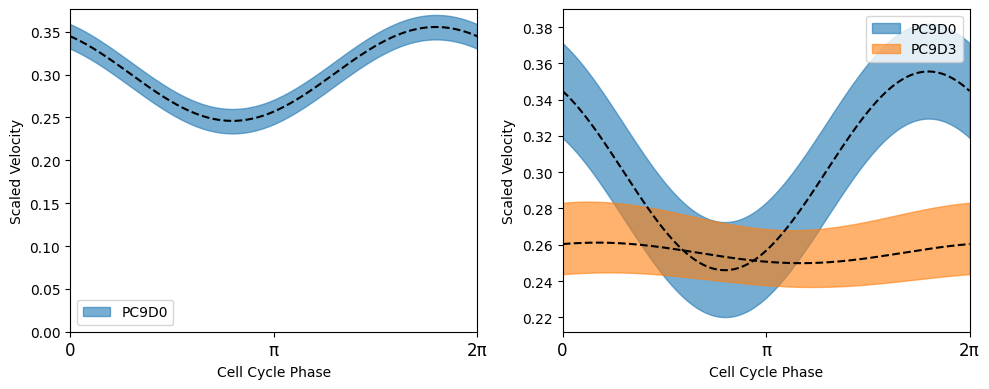

In [58]:
plt.figure(None, (10, 4))

plt.subplot(1, 2, 1)
colors = ["tab:blue", "tab:orange"]
omega = full_pps_velo["ω"].squeeze().numpy() / np.exp(np.mean(log_gammas))
phi = phase_pyro.phis
omegas = []
phis = []
n2n = {"PC9D0":0, "PC9D3":1}
ids = np.array([n2n[i] for i in np.array(data_to_fit.obs["batch"])])
for i in range(len(data_to_fit.obs["batch"].unique())):
    omega1 = omega[:,np.where(ids == i)]
    phi1 = phi[np.where(ids == i)]
    omegas.append(omega1)
    phis.append(phi1)

labels = np.array(data_to_fit.obs["batch"].unique())
for i in range(len(omegas[:1])):
    plt.plot(phis[i][np.argsort(phis[i])], omegas[i].mean(0)[0][np.argsort(phis[i])], c="black", linestyle='dashed')
    
    tmp5 = np.percentile(omega[:, ids==i], 5, axis=0)
    tmp95 = np.percentile(omega[:, ids==i], 95, axis=0)
    phi_i = phi[ids==i] 
    plt.fill_between(x=phi_i[np.argsort(phi_i)],
                     y1=tmp5[np.argsort(phi_i)], 
                     y2=tmp95[np.argsort(phi_i)], 
                     alpha=0.6, color=colors[i], label = labels[i])
plt.xlabel("Cell Cycle Phase")
plt.ylabel("Scaled Velocity")
plt.xlim(0, np.pi*2)
plt.ylim(0, None)
plt.xticks([0, np.pi, 2*np.pi],["0", "π", "2π"], size=12)
plt.legend()

omega = full_pps_velo["ω"].squeeze().numpy() / np.exp(np.mean(log_gammas))
phi = phase_pyro.phis
omegas = []
phis = []
n2n = {"PC9D0":0, "PC9D3":1}
ids = np.array([n2n[i] for i in np.array(data_to_fit.obs["batch"])])
for i in range(len(data_to_fit.obs["batch"].unique())):
    omega1 = omega[:,np.where(ids == i)]
    phi1 = phi[np.where(ids == i)]
    omegas.append(omega1)
    phis.append(phi1)

labels = np.array(data_to_fit.obs["batch"].unique()) #list(adatas.keys())

plt.subplot(1, 2, 2)
for i in range(len(omegas)):
    plt.plot(phis[i][np.argsort(phis[i])], omegas[i].mean(0)[0][np.argsort(phis[i])], c="black", linestyle='dashed')
    
    tmp5 = np.percentile(omega[:, ids==i], 0, axis=0)
    tmp95 = np.percentile(omega[:, ids==i], 100, axis=0)
    phi_i = phi[ids==i] 
    plt.fill_between(x=phi_i[np.argsort(phi_i)],
                     y1=tmp5[np.argsort(phi_i)], 
                     y2=tmp95[np.argsort(phi_i)], 
                     alpha=0.6, color=colors[i], label = labels[i])
plt.xlabel("Cell Cycle Phase")
plt.ylabel("Scaled Velocity")
plt.xlim(0, np.pi*2)
plt.xticks([0, np.pi, 2*np.pi],["0", "π", "2π"], size=12)
plt.tight_layout()
plt.legend()
plt.show()

### (2) Are there differences in cell cycle speed between categorical cell cycle phases?

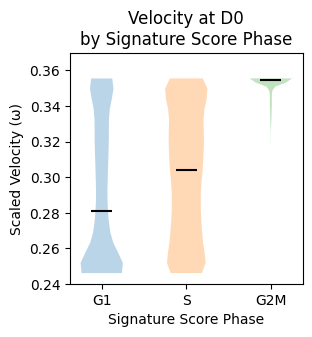

In [59]:
# PC9 D0
import matplotlib.pyplot as plt

plt.figure(None, (3, 3))
b = "PC9D0"
omega = (full_pps_velo["ω"].squeeze().numpy() / torch.exp(torch.mean(full_pps_velo["logγg"].squeeze().mean(0).detach())).numpy())
data1 = omega[:, (data_to_fit.obs["batch"]==b) & (data_to_fit.obs["phase"]=="G1")].mean(0)
data2 = omega[:, (data_to_fit.obs["batch"]==b) & (data_to_fit.obs["phase"]=="S")].mean(0)
data3 = omega[:, (data_to_fit.obs["batch"]==b) & (data_to_fit.obs["phase"]=="G2M")].mean(0)

# Combine the three data subsets into a list
all_data = [data1, data2, data3]

# Create the violin plot
parts = plt.violinplot(all_data, showmedians=True, points=20, showextrema=False)

# Specify the colors you want to use
colors = ['tab:blue', 'tab:orange', 'tab:green']

# Loop to set the colors
for pc, color in zip(parts['bodies'], colors):
    pc.set_facecolor(color)

# Set the color for the mean line
for partname in ('cmedians',):
    part = parts[partname]
    part.set_edgecolor('black')
    part.set_linewidth(1.5)
    
# Customize ticks and labels
plt.xticks([1, 2, 3], ['G1', 'S', 'G2M'])

# Add title and axis labels
plt.title("Velocity at D0\nby Signature Score Phase")
plt.xlabel("Signature Score Phase")
plt.ylabel("Scaled Velocity (ω)")
plt.ylim(0.24, 0.37)
plt.show()

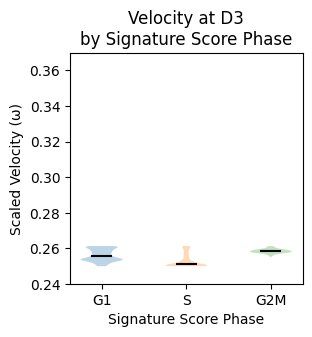

In [60]:
# PC9 D3
import matplotlib.pyplot as plt

plt.figure(None, (3, 3))
b = "PC9D3"
omega = (full_pps_velo["ω"].squeeze().numpy() / torch.exp(torch.mean(full_pps_velo["logγg"].squeeze().mean(0).detach())).numpy())
data1 = omega[:, (data_to_fit.obs["batch"]==b) & (data_to_fit.obs["phase"]=="G1")].mean(0)
data2 = omega[:, (data_to_fit.obs["batch"]==b) & (data_to_fit.obs["phase"]=="S")].mean(0)
data3 = omega[:, (data_to_fit.obs["batch"]==b) & (data_to_fit.obs["phase"]=="G2M")].mean(0)

# Combine the three data subsets into a list
all_data = [data1, data2, data3]

# Create the violin plot
parts = plt.violinplot(all_data, showmedians=True, points=20, showextrema=False)

# Specify the colors you want to use
colors = ['tab:blue', 'tab:orange', 'tab:green']

# Loop to set the colors
for pc, color in zip(parts['bodies'], colors):
    pc.set_facecolor(color)

# Set the color for the mean line
for partname in ('cmedians',):
    part = parts[partname]
    part.set_edgecolor('black')
    part.set_linewidth(1.5)
    
# Customize ticks and labels
plt.xticks([1, 2, 3], ['G1', 'S', 'G2M'])

# Add title and axis labels
plt.title("Velocity at D3\nby Signature Score Phase")
plt.xlabel("Signature Score Phase")
plt.ylabel("Scaled Velocity (ω)")
plt.ylim(0.24, 0.37)
plt.show()

### (3) Do the velocity kinetic parameters and spliced-unspliced delays correlated with one another?

In [61]:
# Investigate changes to the shift along the cell cycle with non-zero harmonic. Should the shift change?
fit_ElogS2 = velocity_fit1.posterior["ElogS2"]
fit_ElogU2 = velocity_fit1.posterior["ElogU2"]
phis = velocity_fit1.phase_pyro.phis
shift_obs = pycircstat.cdiff(phis[np.argmax(fit_ElogS2.numpy().T, axis=0)], phis[np.argmax(fit_ElogU2.numpy().T, axis=0)])

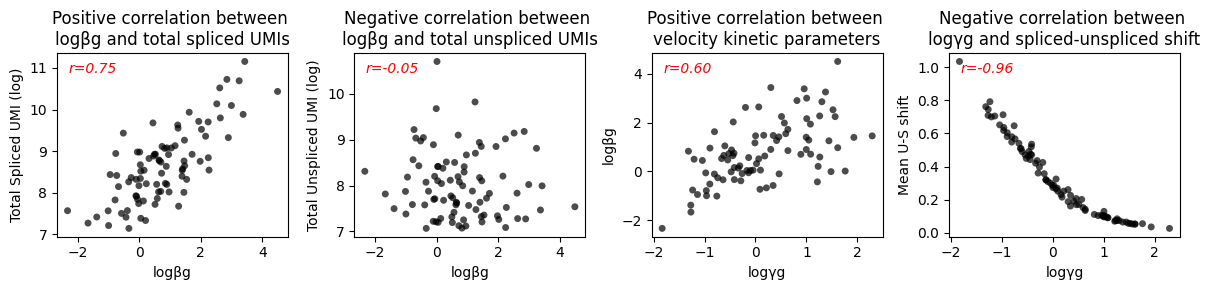

In [62]:
from scipy.stats import pearsonr

# Helper function to compute the Pearson correlation and add it as text to the plot
def add_pearson_corr_text(x, y, ax):
    corr, _ = pearsonr(x, y)
    ax.text(0.05, 0.95, f"r={corr:.2f}", color='red', ha='left', va='top', transform=ax.transAxes, style='italic')

# Initialize the figure
plt.figure(None, (12, 3))

# Splicing rate vs log spliced counts
ax1 = plt.subplot(1, 4, 1)
ax1.scatter(velocity_fit0.log_betas, np.log(data_to_fit.layers["spliced"].toarray().sum(0)), c='black', edgecolor='none', s=25, alpha=0.7, rasterized=True)
plt.xlabel("logβg")
plt.ylabel("Total Spliced UMI (log)")
plt.title("Positive correlation between \nlogβg and total spliced UMIs")
add_pearson_corr_text(velocity_fit1.log_betas, np.log(data_to_fit.layers["spliced"].toarray().sum(0)), ax1)

# Splicing rate vs log unspliced counts
ax2 = plt.subplot(1, 4, 2)
ax2.scatter(velocity_fit0.log_betas, np.log(data_to_fit.layers["unspliced"].toarray().sum(0)), c='black', edgecolor='none', s=25, alpha=0.7, rasterized=True)
plt.xlabel("logβg")
plt.ylabel("Total Unspliced UMI (log)")
plt.title("Negative correlation between \nlogβg and total unspliced UMIs")
add_pearson_corr_text(velocity_fit1.log_betas, np.log(data_to_fit.layers["unspliced"].toarray().sum(0)), ax2)

# Splicing rate vs log spliced counts
ax3 = plt.subplot(1, 4, 3)
ax3.scatter(velocity_fit0.log_gammas, velocity_fit0.log_betas, edgecolor='none', s=25, c='black', alpha=0.7, rasterized=True)
plt.xlabel("logγg")
plt.ylabel("logβg")
plt.title("Positive correlation between \nvelocity kinetic parameters")
add_pearson_corr_text(velocity_fit1.log_gammas, velocity_fit1.log_betas, ax3)

# Plot 4
ax4 = plt.subplot(1, 4, 4)
ax4.scatter(velocity_fit0.log_gammas, shift_obs, edgecolor='none', s=25, c='black', alpha=0.7, rasterized=True)
plt.xlabel("logγg")
plt.ylabel("Mean U-S shift")
plt.title("Negative correlation between \nlogγg and spliced-unspliced shift")
add_pearson_corr_text(velocity_fit1.log_gammas, shift_obs, ax4)

plt.tight_layout()
plt.show()

### (4) If we stratify by sample, do we see differential unspliced-spliced delays for certian genes?

In [63]:
batch = np.array(data_to_fit.obs["batch"])
phis = velocity_fit1.phase_pyro.phis[batch=="PC9D0"]

fit_ElogS2 = velocity_fit1.posterior["ElogS2"][:, batch=="PC9D0"]
fit_ElogU2 = velocity_fit1.posterior["ElogU2"][:, batch=="PC9D0"]

shift_obs_D0 = np.abs(pycircstat.cdiff(phis[np.argmax(fit_ElogS2.numpy().T, axis=0)], phis[np.argmax(fit_ElogU2.numpy().T, axis=0)]))

In [64]:
phis = velocity_fit1.phase_pyro.phis[batch=="PC9D3"]

fit_ElogS2 = velocity_fit1.posterior["ElogS2"][:, batch=="PC9D3"]
fit_ElogU2 = velocity_fit1.posterior["ElogU2"][:, batch=="PC9D3"]

shift_obs_D3 = np.abs(pycircstat.cdiff(phis[np.argmax(fit_ElogS2.numpy().T, axis=0)], phis[np.argmax(fit_ElogU2.numpy().T, axis=0)]))

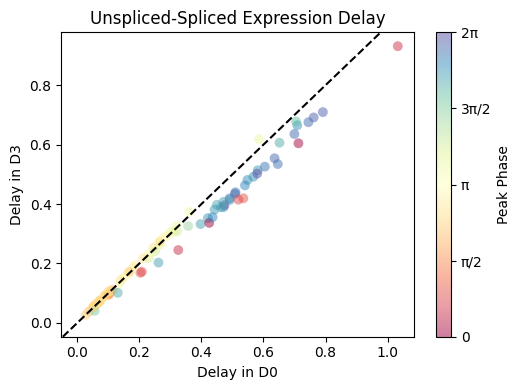

In [65]:
genes = np.array(data_to_fit.var.index)
shift_abs_differences = np.abs(shift_obs_D3-shift_obs_D0)

plt.figure(None, (10, 4))

plt.subplot(1,2,1)
plt.scatter(shift_obs_D0, shift_obs_D3, alpha=0.5, edgecolor="none", s=50, c=cycle_data_frame["peak_phase"], cmap=plt.cm.Spectral, vmax=2*np.pi, vmin=0, rasterized=True)

plt.axline((0,0), slope=1, c='black', linestyle='dashed')
plt.xlabel("Delay in D0")
plt.ylabel("Delay in D3")
plt.title("Unspliced-Spliced Expression Delay")
cbar = plt.colorbar(label="Peak Phase")
cbar.set_ticks([0, np.pi/2, np.pi, 3*np.pi/2, 2*np.pi])
cbar.set_ticklabels(["0", "π/2", "π", "3π/2", "2π"])

plt.tight_layout()
plt.show()

## Finally, save the analysis results as a pickle object (cleaner implementation coming soon!)

In [66]:
del phase_fit.metaparams
del phase_fit.metaparams_avg

del velocity_fit1.metaparams
del velocity_fit1.metaparams_avg

In [67]:
pickle.dump([phase_fit, velocity_fit1], open("pc9_d0_d3_velocycle_output.pkl", "wb"))